# Simple ARIMA model for non-seasonal time-serie forecast

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

##  1. Load Data and Plot Time Series
Let's start by loading the time series of the challenge and plot the time series

In [2]:
import pandas as pd

data = pd.read_csv('data/daily_restaurant_sales.csv')
data

,x
0,88
1,84
2,85
3,85
4,84
...,...
95,222
96,228
97,226
98,222


This abstract time serie does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regresive Moving Average (ARIMA) models


## 2. Build ARIMA model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time serie (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the Moving-Average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure stationarity

ARIMA models applies to "stationary" time series only.

👉 Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [3]:
from statsmodels.tsa.stattools import adfuller

# run ADF test on the time series
result = adfuller(data['x'])

# extract p-value from test results
p_value = result[1]

# print p-value
print(f"P-value: {p_value:.4f}")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


P-value: 0.1244


The p-value should be  less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat process on the differentiated serie if you want the *second difference*, etc...

👉 Find the minimum order of differencing we need to make it stationnary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

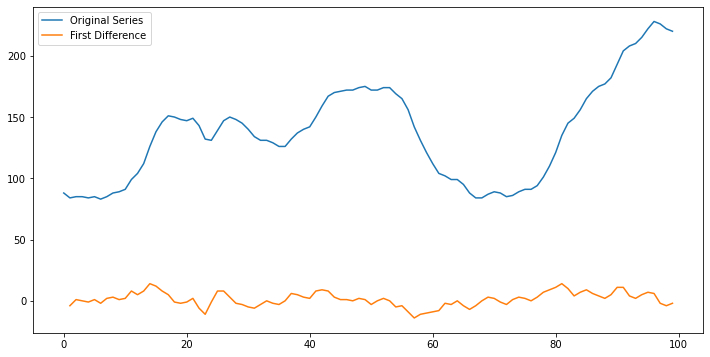

P-value after first difference: 0.0703


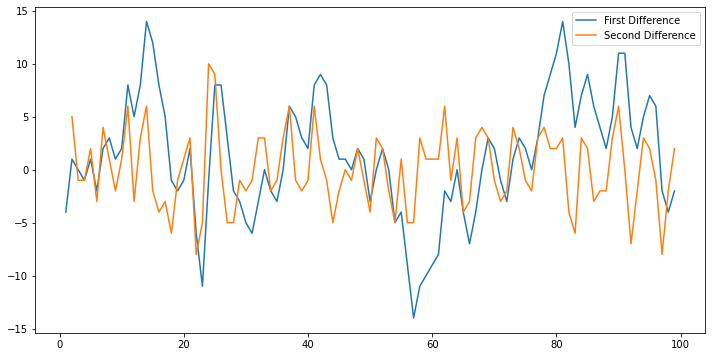

P-value after second difference: 0.0000


In [4]:
import matplotlib.pyplot as plt

# calculate first difference
diff_1 = data['x'].diff().dropna()

# plot the original and differenced series
plt.figure(figsize=(12, 6))
plt.plot(data['x'], label='Original Series')
plt.plot(diff_1, label='First Difference')
plt.legend()
plt.show()

# run ADF test on first difference
result = adfuller(diff_1)
p_value = result[1]

# print p-value
print(f"P-value after first difference: {p_value:.4f}")

# calculate second difference
diff_2 = diff_1.diff().dropna()

# plot the first and second difference
plt.figure(figsize=(12, 6))
plt.plot(diff_1, label='First Difference')
plt.plot(diff_2, label='Second Difference')
plt.legend()
plt.show()

# run ADF test on second difference
result = adfuller(diff_2)
p_value = result[1]

# print p-value
print(f"P-value after second difference: {p_value:.4f}")

We have a close-call here between one and two diff orders. Differentiating too much a time series may also reduce performance of your ARIMA models. Let's have a closer look:

👉 Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(💡Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

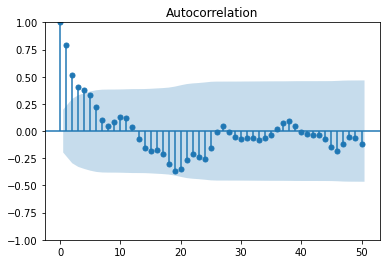

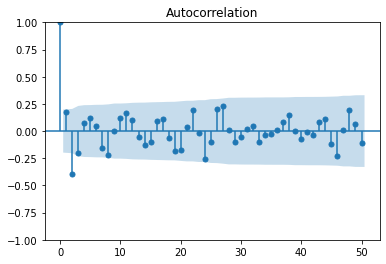

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

# autocorrelation plot for diff order 1
plot_acf(data.diff().dropna(), lags=50);

# autocorrelation plot for diff order 2
plot_acf(data.diff().diff().dropna(), lags=50);

In our "second order diff" autocorrelation plot, the lag coefficient n°1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n°0 which is always equal to 1)

👉 Let's (temptatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

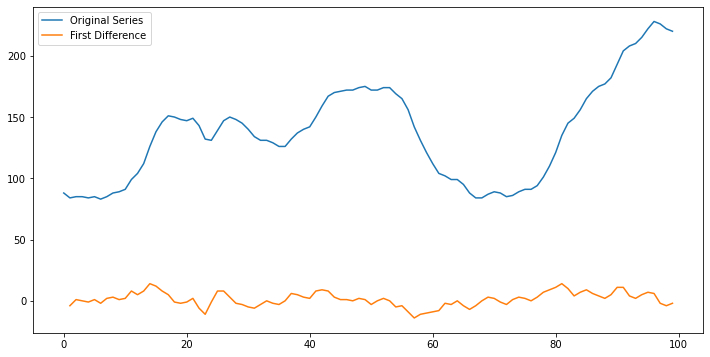

P-value after first difference: 0.0703


In [6]:
y_diff = data['x'].diff().dropna()

# plot the original and differenced series
plt.figure(figsize=(12, 6))
plt.plot(data['x'], label='Original Series')
plt.plot(y_diff, label='First Difference')
plt.legend()
plt.show()

# run ADF test on first difference
result = adfuller(y_diff)
p_value = result[1]

# print p-value
print(f"P-value after first difference: {p_value:.4f}")

We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary (I refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

👉 determine `q`

q vaut 5


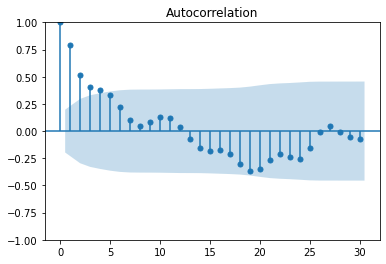

In [7]:
from statsmodels.tsa.stattools import acf

plot_acf(y_diff, lags=30)

print('q vaut 5')

We could choose q = 4, but it's more conservatively to try with `q=2` to start with.

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

👉 Determine `p`

C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


p vaut 3


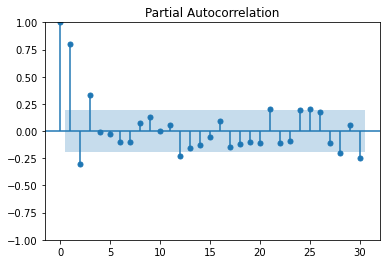

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import numpy as np

plot_pacf(y_diff, lags=30)

print('p vaut 3')

We could choose `p = 3` as the first 3 lag terms seems above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d` and `q` for the ARIMA, 

👉 build the `arima_model` from `statsmodels`.
- fit the the model
- print the model (`.summary`)

In [9]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(y_diff, order=(1,1,1))
arima_results = arima_model.fit()
print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -258.796
Date:                Wed, 08 Mar 2023   AIC                            523.592
Time:                        09:54:18   BIC                            531.347
Sample:                             0   HQIC                           526.729
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2661      0.215     -1.238      0.216      -0.688       0.155
ma.L1          0.6139      0.169      3.635      0.000       0.283       0.945
sigma2        11.4929      1.666      6.897      0.0

C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


☝️ If your p-values are too high, try remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate overall performance of your fit by minimizing the [`AIC - akaike information criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remains low) and maintain a quasi similar AIC score than other models

## 3. Evaluate model performance

👉 Visualize your model predictions with `.plot_predict()`

- Look closely at the method default params, especially `dynamic`. 
- Do you think your model would have such good performance in reality?

Forecasted values: 99    -1.810169
100   -1.860691
101   -1.847245
102   -1.850824
103   -1.849871
104   -1.850125
105   -1.850057
106   -1.850075
107   -1.850070
108   -1.850072
109   -1.850071
110   -1.850071
111   -1.850071
112   -1.850071
113   -1.850071
114   -1.850071
115   -1.850071
116   -1.850071
117   -1.850071
118   -1.850071
Name: predicted_mean, dtype: float64


C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


NameError: name 'conf_int' is not defined

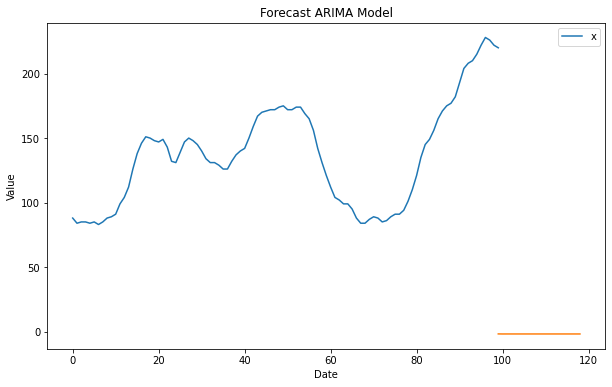

In [10]:
#arima_results.plot_predict()
#plt.show()

forecast = arima_results.forecast(steps=20)
print("Forecasted values:", forecast)
ax = data.plot(label='Observations', figsize=(10,6))
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Forecast ARIMA Model')
forecast_plot = ax.plot(forecast, label='Forecast')
ax.fill_between(data.index[-1:].append(pd.date_range(start=data.index[-1], periods=20, freq='M')), 
                conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='Confidence Intervals')
plt.legend(loc='upper left')
plt.show()

☝️ `dynamic=False` actually makes use of all available values `y` in order to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

👉 Try to use `dynamic=True` to plot a prection of the _last 15 values_ in a situation where the model only have _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ it's previouly predicted value for 86
- etc...iteratively until 100

In [11]:
arima_model = ARIMA(y_diff[:85], order=(1,1,1))
arima_results = arima_model.fit()

pred_start = len(y_diff[:85])
pred_end = len(y_diff)
dynamic_pred = arima_results.predict(start=pred_start, end=pred_end, dynamic=True)

C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


☝️ That's still not a _true_ forecast!! Why??

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` serie during the fitting phase!
</details>

### 3.1 Out-of-sample forecasts (real "future")

👉 Create a train-test-split keep the last 15 datapoints only for the test set, and train your ARIMA on the train set only.

In [12]:
train = data.iloc[:-15]
test = data.iloc[-15:]

arima_model = ARIMA(train, order=(1,1,1))
arima_results = arima_model.fit()

👉 We are "now" in step 85 and have never seen the future:
- Use `.forecast()` method on your fitted model to "forecast" the 15 next datapoints (i.e beyond the end of your train dataset) 
- Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

15


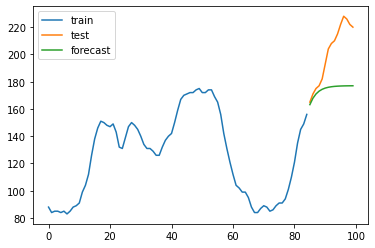

In [22]:
forecast_values = arima_results.forecast(steps=15)
print(len(forecast_values))

forecast = arima_results.forecast(steps=15)

plt.plot(train.index, train.values, label='train')
plt.plot(test.index, test.values, label='test')
plt.plot(test.index, forecast, label='forecast')

plt.legend()
plt.show()

👉 Try to also plot your previous 85 `y` real datapoints to better grasp model performance relative to the past

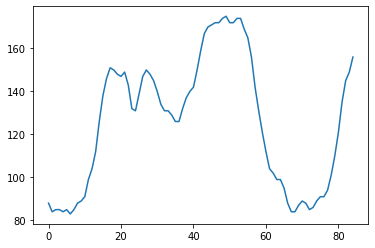

In [23]:
plt.plot(train.index[-85:], train.values[-85:], label='past')
plt.show()

### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

👉 Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals if you really want)

Note: residuals are constructed by 'seing' all data as in `plot_predict(dynamic=False)`

Also try to plot a histogram or kde fit of the residuals to see if they are approximately normally distributed.

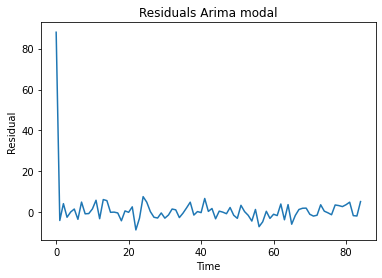

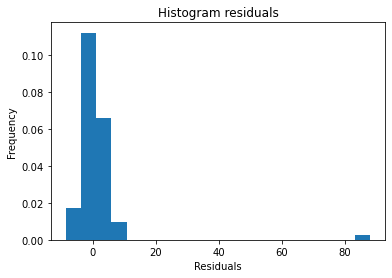

In [25]:
residuals = arima_results.resid

plt.plot(residuals)
plt.title('Residuals Arima modal')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.show()

plt.hist(residuals, bins=20, density=True)
plt.title('Histogram residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

## 3.3 Cross-validated performance metrics

👉 Below are the given the most common performance metrics for time series

In [26]:
import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

👉 Play with you ARIMA hyper-parameters and see the impact on your forecast performance

In [28]:
p_range = range(0, 5)
d_range = range(0, 3)
q_range = range(0, 5)

best_score = np.inf

for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                model = ARIMA(train.values, order=(p,d,q))
                arima_results = model.fit()

                # Prédire les prochaines 15 valeurs avec le modèle
                forecast = arima_results.forecast(steps=15)

                # Calculer les performances de prévision pour les 15 valeurs prédites
                forecast_accuracy_metrics = forecast_accuracy(forecast, test)

                # Stocker le score de performance actuel
                current_score = forecast_accuracy_metrics['rmse']

                # Si le score actuel est meilleur que le meilleur score actuel, mettre à jour le meilleur score
                if current_score < best_score:
                    best_score = current_score
                    best_p = p
                    best_d = d
                    best_q = q
            except:
                pass

# Créer le modèle ARIMA avec les meilleurs hyperparamètres trouvés
best_model = ARIMA(train.values, order=(p, d, q))

C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\base\model.py:6

## 4 Grid Search
#link to understand Grid Search https://www.lovelyanalytics.com/2017/10/16/grid-search/

Try to run your own gridsearch for (p,d,q) using `pmdarima`. Use at least
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [32]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import auto_arima

In [34]:
d = ndiffs(data, test='adf')

results = pm.arima.arima.ARIMA(
    order=(0, d, 0),
    seasonal_order=(0,0,0,0),
    suppress_warnings=True,
    trace=True,
    error_action='ignore',
    scoring='mse'
).fit(data)

print(results.aic())

model = auto_arima(data,
                   seasonal=False,
                   suppress_warnings=True,
                  error_action='ignore',
                  trace=True)

print(model.summary())

533.4738497716232
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=531.096, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1277.994, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=534.894, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=529.183, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=564.832, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=2.44 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=532.642, Time=0.63 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=526.492, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=564.487, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=538.940, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=528.28

## Cross-validate performance of your model

In practice, Results and GridSearch should always be cross validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create continguous K-folds so as to truely evaluate the performance of your model and find the best hyper-params after cross validation

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0101.png'>

In [35]:
from sklearn.model_selection import TimeSeriesSplit

In [46]:
tscv = TimeSeriesSplit(n_splits=5)
p = range(0, 3)
d = range(0, 3)
q = range(0, 3)

results = {}

for i in p:
    for j in d:
        for k in q:
            # Create an ARIMA model with the current hyperparameters
            model = ARIMA(train, order=(i, j, k))

            # Create an empty list to store the forecasted values
            forecast = []

            # Loop over each split in the time series cross-validation
            for train_index, test_index in tscv.split(train):
                model_fit = model.fit(train)
                if len(model_fit.forecast()) > 0:

                    # Use the fitted model to make a forecast for the test data
                    y_pred = model_fit.forecast(len(test_index))[0]

                    # Append the forecasted values to the list
                    forecast.extend(y_pred)

            # Calculate the forecast accuracy for the current hyperparameters
            accuracy = forecast_accuracy(pd.Series(forecast), pd.Series(test_data))

            # Store the results in the dictionary
            results[(i, j, k)] = accuracy
            
best_params = max(results, key=results.get)
print(best_params)

KeyError: 0